Dependency

```python
!pip install ase
!pip install matplotlib
!pip install numpy
!pip install pandas
!pip install scikit-learn
!pip install MDAnalysis
!pip install tidynamics
```

In [ ]:
from ase import Atoms
from ase.build import molecule
from ase.io import write, read
import numpy as np
from scipy.spatial.transform import Rotation as R
from tkinter.filedialog import askopenfilename
import os

desktop_dir = os.path.join(os.path.expanduser("~"), "Desktop")

# Read cell parameters from CIF file
cif_path = askopenfilename(title="Select CIF file", filetypes=[("CIF files", "*.cif")])
slab = read(cif_path)
cell = slab.get_cell()
box_x, box_y, box_z, alpha, beta, gamma = slab.get_cell_lengths_and_angles()

# Set z_surface based on the atom with the largest z value in the slab
z_surface = max(slab.positions[:, 2])
z_offset = 3.0  # vertical offset for water molecules above the surface

# Number of molecular layers to add
num_layers = 3  # user-defined number of layers
min_spacing = 2.8  # user-defined minimum spacing between water molecules
start_z = z_surface + z_offset

# Cell vetors
a_vec, b_vec, c_vec = cell[0], cell[1], cell[2]

# Maximum number of molecules in each direction
max_i = int(np.linalg.norm(a_vec) // min_spacing)
max_j = int(np.linalg.norm(b_vec) // min_spacing)

# Adjust spacing to ensure uniform distribution under PBC
adjusted_spacing_x = np.linalg.norm(a_vec) / max_i if max_i > 0 else np.linalg.norm(a_vec)
adjusted_spacing_y = np.linalg.norm(b_vec) / max_j if max_j > 0 else np.linalg.norm(b_vec)

# Recalculate origin offset for center alignment
origin_shift_x = (np.linalg.norm(a_vec) - (max_i - 1) * adjusted_spacing_x) / 2 if max_i > 1 else 0
origin_shift_y = (np.linalg.norm(b_vec) - (max_j - 1) * adjusted_spacing_y) / 2 if max_j > 1 else 0

# Define water molecule
water = molecule("H2O")
water.translate(-water.get_center_of_mass())  # center water moecule at origin

waters = []

for k in range(num_layers):
    for j in range(max_j):
        for i in range(max_i):
            pos_vector = i * adjusted_spacing_x * a_vec / np.linalg.norm(a_vec) + \
                         j * adjusted_spacing_y * b_vec / np.linalg.norm(b_vec) + \
                         k * min_spacing * np.array([0, 0, 1]) + \
                         origin_shift_x * a_vec / np.linalg.norm(a_vec) + \
                         origin_shift_y * b_vec / np.linalg.norm(b_vec) + \
                         np.array([0, 0, start_z])

            if pos_vector[2] > (box_z - min_spacing):
                print("Reached top of cell. Stopping placement.")
                break

            new = water.copy()

            rot = R.random().as_matrix()
            new.positions = np.dot(new.positions, rot.T)

            new.translate(pos_vector)
            waters.append(new)

# Merge all water molecules into a single Atoms object
combined = sum(waters[1:], waters[0].copy()) if waters else Atoms()
symbols = combined.get_chemical_symbols()

from collections import defaultdict
symbol_to_indices = defaultdict(list)
for idx, symbol in enumerate(symbols):
    symbol_to_indices[symbol].append(idx)

sorted_symbols = sorted(symbol_to_indices.keys())

new_order = []
for symbol in sorted_symbols:
    new_order.extend(symbol_to_indices[symbol])
combined = combined[new_order]

slab += combined 
slab.set_cell(cell)
slab.set_pbc([True, True, True])

# Save the final structure as CIF file
write(os.path.join(desktop_dir, "water_added.cif"), slab)

In [ ]:
from ase.io import read, write
from MDAnalysis import Universe

# ASE에서 Cartesian 변환된 XYZ 저장
atoms_1 = read("XDATCAR", index=":")
write("traj.xyz", atoms_1)

In [ ]:
from ase.io import read, write
from ase.geometry.cell import cellpar_to_cell
from ase.visualize import view
import os

project_name = "Cu"
home_dir = os.path.join(os.path.expanduser("~"), "Desktop")

cif_atoms = read(os.path.join(home_dir, f"{project_name}.cif"))
cell = cif_atoms.get_cell()

frames = read(os.path.join(home_dir, f"{project_name}-pos-1.xyz"), index=':')


for atoms_1 in frames:
    atoms_1.set_cell(cell)
    atoms_1.set_pbc([True, True, True])

write(os.path.join(home_dir, f"{project_name}.traj"), frames)


In [ ]:
from ase.io import read, write
import os

project_name = "CeO2_Cu"
home_dir = os.path.join(os.path.expanduser("~"), "Desktop")
trajectory = os.path.join(home_dir, f"{project_name}-pos-1.xyz")
cif_file = os.path.join(home_dir, f"{project_name}.cif")

traj = read(trajectory, index=":")
last = traj[-1]

cell = read(cif_file).get_cell()

last.set_cell(cell)
last.set_pbc([True, True, True])

write(os.path.join(home_dir, f"{project_name}_last_frame.cif"), last)

In [ ]:
from ase.io import read, write

filename = "CeO2"
n = 1000
cif_atoms = read(f"C:\\Users\\Jihoon\\Desktop\\{filename}.cif")
cell = cif_atoms.get_cell()

# 3. XYZ 위치 데이터 읽기 (격자 정보 무시)
frames = read(f"C:\\Users\\Jihoon\\Desktop\\{filename}-pos-1.xyz", index=":")

write(f"C:\\Users\\Jihoon\\Desktop\\{filename}_new.xyz", frames[n:])

# 🔬 **Visualization Tool using ASE**

**Method:**  
Use a File Dialog and Select Structure File or Trajectory File

**Supported Features:**

* Supported file formats: `.cif`, `.xyz`, `VASP`, `.pdb`, `.traj`
* Opens in a separate interactive window
* Does not block the Jupyter Notebook cell
* Returns the loaded structure as an `ASE Atoms` object

**⚠️ Notes:**

* The GUI window must be closed before proceeding to the next cell
* X11 forwarding may be required on Linux/WSL environments

In [ ]:
import os
from ase.io import read
from ase.gui.gui import GUI
from tkinter.filedialog import askopenfilename
import threading
import warnings

# Ignore GUI related warning messages in Jupyter condition
warnings.filterwarnings('ignore', category=UserWarning, module='matplotlib')

def open_file_dialog():
    """Select structure file through filedialog box"""
    fname = askopenfilename(
        title="Select structure file",
        filetypes=[
            ("VASP files", "*.vasp *.poscar *.contcar *POSCAR* *CONTCAR*"),
            ("CIF files", "*.cif"), 
            ("XYZ files", "*.xyz"),
            ("PDB files", "*.pdb"),
            ("Trajectory files", "*.traj"),
            ("All supported files", "*.cif *.xyz *.vasp *.poscar *.contcar *.pdb *.traj"),
            ("All files", "*.*")
        ]
    )
    return fname

def load_structure(filename):
    """load structure file and extract informations"""
    if not filename:
        print("❌ No file selected.")
        return None
    
    if not os.path.exists(filename):
        print(f"❌ Error: File '{filename}' does not exist.")
        return None
    
    try:
        print(f"📁 Reading file: {os.path.basename(filename)}")
        try:
            atoms = read(filename, index=':')
        except Exception:
            # if reading fails, try to read as a single structure
            atoms = read(filename)
        
        if not atoms:
            print("❌ No structure(s) found in file.")
            return None
            
        return atoms
        
    except Exception as e:
        print(f"❌ Failed to read file '{os.path.basename(filename)}': {e}")
        return None

def open_gui_threaded(atoms):
    """Run ASE GUI in a separate thread to avoid blocking Jupyter"""
    try:
        print("🖥️  Opening ASE GUI...")
        print("(GUI will open in a separate window)")
        gui = GUI(images=atoms)
        gui.run()
        print("✅ ASE GUI closed.")
    except Exception as e:
        print(f"❌ Failed to open GUI: {e}")

def open_file():
    """Main function to open file dialog and load structure"""
    # Select file using dialog
    filename = open_file_dialog()
    
    # Load structure from selected file
    atoms = load_structure(filename)
    if atoms is None:
        return None
    
    # Run GUI in a separate thread
    gui_thread = threading.Thread(target=open_gui_threaded, args=(atoms,))
    gui_thread.daemon = True
    gui_thread.start()
    
    return atoms


# Show usage instructions
open_file()

# **RDF**

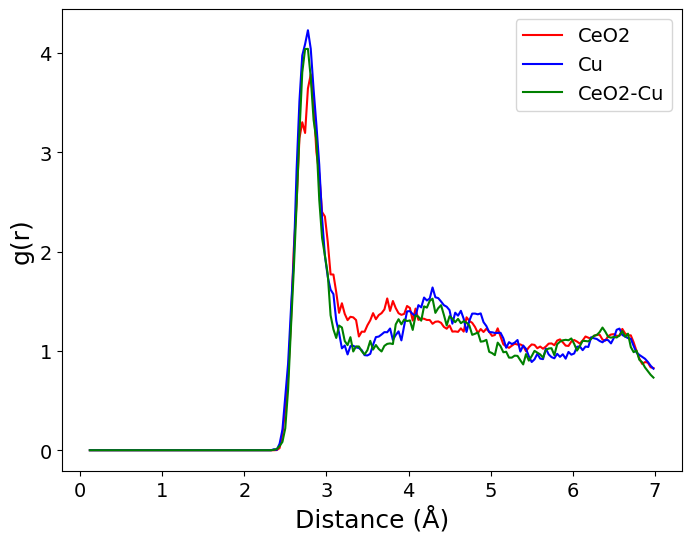

In [11]:
import MDAnalysis as mda
from MDAnalysis.analysis.rdf import InterRDF
import matplotlib.pyplot as plt
import numpy as np
from ase.io import read
import os

desktop_dir = os.path.join(os.path.expanduser("~"), "Desktop")
name_1 = "CeO2"
name_2 = "Cu"
name_3 = "CeO2_Cu"

cif_path_1 = os.path.join(desktop_dir, f"{name_1}.cif")
cif_path_2 = os.path.join(desktop_dir, f"{name_2}.cif")
cif_path_3 = os.path.join(desktop_dir, f"{name_3}.cif")

# CIF 파일 읽기

atoms_1 = read(cif_path_1)
atoms_2 = read(cif_path_2)
atoms_3 = read(cif_path_3)

# 격자 벡터 lengths
cellpar1 = atoms_1.cell.cellpar()
cellpar2 = atoms_2.cell.cellpar()
cellpar3 = atoms_3.cell.cellpar()

traj_path_1 = os.path.join(desktop_dir, f"{name_1}-pos-1.xyz")
traj_path_2 = os.path.join(desktop_dir, f"{name_2}-pos-1.xyz")
traj_path_3 = os.path.join(desktop_dir, f"{name_3}-pos-1.xyz")

# Read trajectory file using MDAnalysis
u1 = mda.Universe(traj_path_1)
u2 = mda.Universe(traj_path_2)
u3 = mda.Universe(traj_path_3)

u1.dimensions = np.array(cellpar1)
u2.dimensions = np.array(cellpar2)
u3.dimensions = np.array(cellpar3)



u1_ag1 = u1.select_atoms('bynum 205:252') 
u2_ag1 = u2.select_atoms('name O')
u3_ag1 = u3.select_atoms('bynum 227:274')


# RDF 계산
rdf1 = InterRDF(u1_ag1, u1_ag1, nbins=200, range=(0.1, 7.0), norm="density")
rdf1.run(start=1000, stop=2000, step=1)

rdf2 = InterRDF(u2_ag1, u2_ag1, nbins=200, range=(0.1, 7.0), norm="density")
rdf2.run(start=1000, stop=2000, step=1)

rdf3 = InterRDF(u3_ag1, u3_ag1, nbins=200, range=(0.1, 7.0), norm="density")
rdf3.run(start=2000, stop=3000, step=1)

# 결과 시각화
plt.figure(figsize=(8,6))
plt.plot(rdf1.bins, rdf1.rdf, label='CeO2', color='red')
plt.plot(rdf2.bins, rdf2.rdf, label='Cu', color='blue')
plt.plot(rdf3.bins, rdf3.rdf, label='CeO2-Cu', color='green')


#plt.xlim(-0.2, 6)
#plt.ylim(-0.2, 4.8)
plt.legend(fontsize=14, loc='upper right')
plt.xlabel('Distance (Å)', fontsize=18)
plt.ylabel('g(r)', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.title('Radial Distribution Function',fontsize=20, fontweight='bold')
plt.show()

In [ ]:
import MDAnalysis as mda
from MDAnalysis.analysis.rdf import InterRDF
import matplotlib.pyplot as plt
import numpy as np
from tkinter import filedialog
from ase.io import read
import os

project_name = "Cu"

home_dir = os.path.join(os.path.expanduser("~"), "Desktop")

cif_file_path = os.path.join(home_dir, f"{project_name}.cif")
trajecotry_file_path = os.path.join(home_dir, f"{project_name}-pos-1.xyz")


atoms_1 = read(cif_file_path)
cellpar1 = atoms_1.cell.cellpar()


u1 = mda.Universe(trajecotry_file_path)
u1.dimensions = np.array(cellpar1)


u1_ag_O = u1.select_atoms('name O and (prop z < 12)')
u1_ag_H = u1.select_atoms("name H and (prop z < 12)")
u1_ag_Cu = u1.select_atoms("name Cu and (prop z > 5)")


# RDF 계산
rdf1 = InterRDF(u1_ag_Cu, u1_ag_O, nbins=200, range=(0.1, 7.0), norm="none")
rdf2 = InterRDF(u1_ag_Cu, u1_ag_H, nbins=200, range=(0.1, 7.0), norm="none")
rdf1.run(start=100, stop=1300, step=1)
rdf2.run(start=100, stop=1300, step=1)


print(rdf1.rdf[199])


# 결과 시각화
plt.figure(figsize=(8,6))
plt.plot(rdf1.bins, rdf1.rdf, label='Cu-O', color='red')
plt.plot(rdf2.bins, rdf2.rdf, label='Cu-H', color='blue')


#plt.xlim(-0.2, 6)
#plt.ylim(-0.2, 4.8)
plt.legend(fontsize=14, loc='upper right')
plt.xlabel('Distance (Å)', fontsize=18)
plt.ylabel('g(r)', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.title('Radial Distribution Function',fontsize=20, fontweight='bold')
plt.show()

# **MSD**

100%|██████████| 48/48 [00:00<00:00, 8948.64it/s]


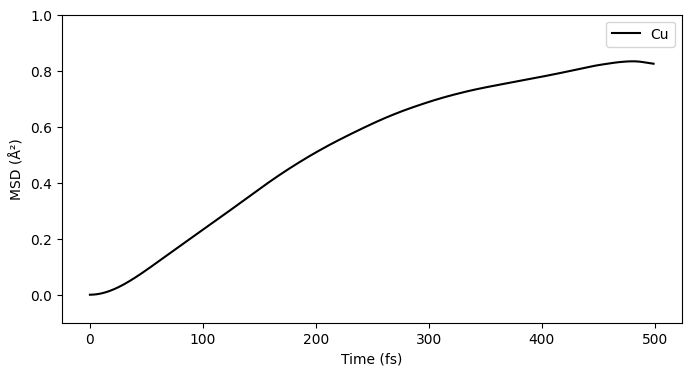

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import MDAnalysis as mda
from MDAnalysis.analysis.msd import EinsteinMSD
import os

# Universe 객체 생성
name = "Cu"
desktop_dir = os.path.join(os.path.expanduser("~"), "Desktop")
xyz_name = os.path.join(desktop_dir, f"{name}-pos-1.xyz")


u = mda.Universe(xyz_name)
u1_ag_O_all = u.select_atoms('name O')

# MSD 분석 수행
msd_analysis = EinsteinMSD(u1_ag_O_all, select="all", msd_type='xyz', fft=True)
msd_analysis.run(start=1500, stop=2000, step=1)

# 결과 추출
msd = msd_analysis.results.timeseries
# 시뮬레이션 파라미터
nframes = msd_analysis.n_frames
timestep = 1  # 프레임 간 시간 간격을 실제 시뮬레이션 값으로 설정하세요
lagtimes = np.arange(nframes) * timestep

# MSD 플롯
plt.figure(figsize=(8, 4))
plt.plot(lagtimes, msd, color='black', linestyle='-', label=name)
#plt.plot(lagtimes /1000 , lagtimes * 6 / 1000, color='black', linestyle='--', label='y=6τ')
plt.ylim(-0.1, 1)
plt.xlabel('Time (fs)')
plt.ylabel('MSD (Å²)')
plt.legend()
plt.show()


In [7]:
from ase.io import read
import numpy as np

name = "CeO2"
path = "C:\\Users\\Jihoon\\Desktop\\"
cif_name = f"{path}{name}.cif"

atoms = read(cif_name)

# Ce 원자 index, z 좌표 추출
ce_indices = [i for i, atom in enumerate(atoms) if atom.symbol == 'Ce']
ce_zs = np.array([atoms[i].position[2] for i in ce_indices])

# 가장 높은 z, 가장 낮은 z 추출 (외곽)
z_tol = 1
z_max = np.max(ce_zs)
z_min = np.min(ce_zs)

print(z_max)
print(z_min)
# tolerance 범위 내 원자 그룹 선택
upper_ce = [ce_indices[i] for i, z in enumerate(ce_zs) if abs(z - z_max) < z_tol]
lower_ce = [ce_indices[i] for i, z in enumerate(ce_zs) if abs(z - z_min) < z_tol]

# index 1-based (CIF/XYZ 기준)
upper_ce_idx = [i+1 for i in upper_ce]
lower_ce_idx = [i+1 for i in lower_ce]

print("Uppermost Ce atom indices:", upper_ce_idx)
print("Lowermost Ce atom indices:", lower_ce_idx)


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Jihoon\\Desktop\\CeO2.cif'

In [ ]:
import MDAnalysis as mda
from MDAnalysis.analysis.rdf import InterRDF
import matplotlib.pyplot as plt
import numpy as np
from tkinter import filedialog
from ase.io import read


name = "CeO2"
path = "C:\\Users\\Jihoon\\Desktop\\"
cif_name = f"{path}{name}.cif"
xyz_name = f"{path}{name}_new.xyz"
start_frame = 1
end_frame = 1000

atoms_1 = read(cif_name)
cellpar1 = atoms_1.cell.cellpar()


u1 = mda.Universe(xyz_name)
u1.dimensions = np.array(cellpar1)


u1_ag_O = u1.select_atoms('name O and (prop z > 10) and (prop z <= 13)')
u2_ag_O = u1.select_atoms('name O and (prop z > 13) and (prop z <= 16)')
u3_ag_O = u1.select_atoms('name O and (prop z > 16) and (prop z <= 19)')
u1_ag_O_all = u1.select_atoms('name O and (prop z > 10)')

# RDF 계산

rdf1 = InterRDF(u1_ag_O, u1_ag_O_all, nbins=200, range=(0.1, 7.0), norm="density")
rdf1.run(start=start_frame, stop=end_frame, step=1)

rdf2 = InterRDF(u2_ag_O, u1_ag_O_all, nbins=200, range=(0.1, 7.0), norm="density")
rdf2.run(start=start_frame, stop=end_frame, step=1)

rdf3 = InterRDF(u3_ag_O, u1_ag_O_all, nbins=200, range=(0.1, 7.0), norm="density")
rdf3.run(start=start_frame, stop=end_frame, step=1)


print(rdf1.rdf[99])


# 결과 시각화
plt.figure(figsize=(8,6))
plt.plot(rdf1.bins, rdf1.rdf / rdf1.rdf[199], label='10-13 Å', color='red')
plt.plot(rdf2.bins, rdf2.rdf / rdf2.rdf[199], label='13-16 Å', color='blue')
plt.plot(rdf3.bins, rdf3.rdf / rdf3.rdf[199], label='16-19 Å', color='green')


#plt.xlim(-0.2, 6)
#plt.ylim(-0.2, 4.8)
plt.legend(fontsize=14, loc='upper right')
plt.xlabel('Distance (Å)', fontsize=18)
plt.ylabel('g(r)', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.title('Radial Distribution Function',fontsize=20, fontweight='bold')
plt.show()

In [ ]:
import os
desktop_dir = os.path.expanduser("~\\Desktop\\")
print(desktop_dir)
name = "CeO2_Cu"
file_path = os.path.join(desktop_dir, f"{name}_new.xyz")
print(file_path)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import MDAnalysis as mda
from MDAnalysis.analysis.msd import EinsteinMSD
import os

# Universe 객체 생성
name = "CeO2"
desktop_dir = os.path.join(os.path.expanduser("~"), "Desktop")
file_path = os.path.join(desktop_dir, f"{name}-pos-1.xyz")


u = mda.Universe(file_path)
u1_ag_O_all = u.select_atoms('name O and (prop z > 9)')

# MSD 분석 수행
msd_analysis = EinsteinMSD(u1_ag_O_all, select="all", msd_type='xyz', fft=True)
msd_analysis.run(start=1500, stop=2000, step=1)

# 결과 추출
msd = msd_analysis.results.timeseries
# 시뮬레이션 파라미터
nframes = msd_analysis.n_frames
timestep = 1  # 프레임 간 시간 간격을 실제 시뮬레이션 값으로 설정하세요
lagtimes = np.arange(nframes) * timestep

# MSD 플롯
plt.figure()
plt.plot(lagtimes, msd, color='black', linestyle='-', label='MSD')
plt.xlabel('Time (τ)')
plt.ylabel('MSD (Å²)')
plt.legend()
plt.show()


0.5328947368421053


C:\Users\user\AppData\Roaming\Python\Python310\site-packages\MDAnalysis\analysis\rdf.py:369: DeprecationWarning: The `rdf` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.rdf` instead
  warnings.warn(wmsg, DeprecationWarning)
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\MDAnalysis\analysis\rdf.py:359: DeprecationWarning: The `bins` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.bins` instead
  warnings.warn(wmsg, DeprecationWarning)


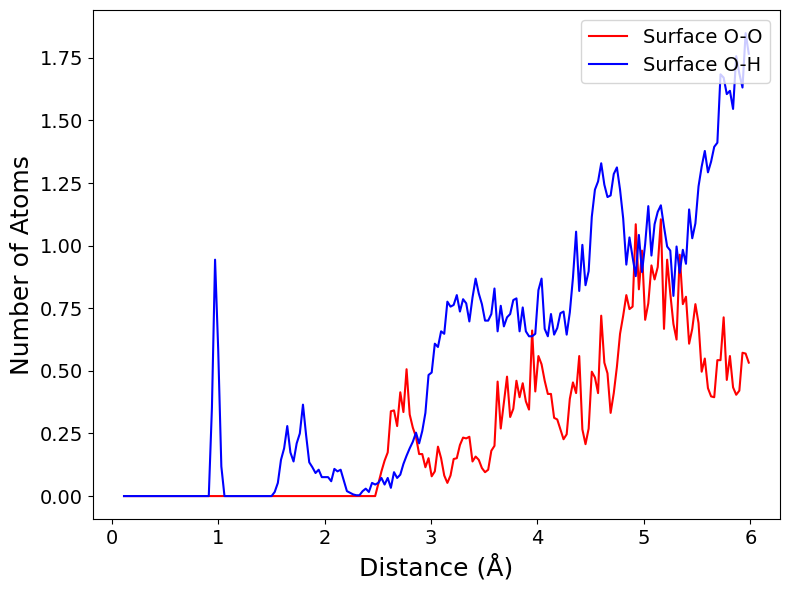

In [ ]:
import MDAnalysis as mda
from MDAnalysis.analysis.rdf import InterRDF
import matplotlib.pyplot as plt
import numpy as np
from ase.io import read
import os

name = "CeO2"
home_dir = os.path.join(os.path.expanduser("~"), "Desktop")
cif_path = os.path.join(home_dir, f"{name}.cif")
xyz_path = os.path.join(home_dir, f"{name}-pos-1.xyz")

atoms_1 = read(cif_path)
cellpar1 = atoms_1.cell.cellpar()


u1 = mda.Universe(xyz_path)
u1.dimensions = np.array(cellpar1)

u1_ag_Ce = u1.select_atoms("prop z > 7 and (name Ce)")
u1_ag_surface_O = u1.select_atoms('prop z > 10 and (prop z < 11) and (name O) ')
u1_ag_H = u1.select_atoms("name H and (prop z > 11) and (prop z < 15)")
u1_ag_O = u1.select_atoms('name O and (prop z > 11) and (prop z < 15)')


# RDF 계산
rdf1 = InterRDF(u1_ag_surface_O, u1_ag_O, nbins=200, range=(0.1, 6.0), norm="none")
rdf2 = InterRDF(u1_ag_surface_O, u1_ag_H, nbins=200, range=(0.1, 6.0), norm="none")
rdf3 = InterRDF(u1_ag_Ce, u1_ag_O, nbins=200, range=(0.1, 6.0), norm="none")
rdf4 = InterRDF(u1_ag_Ce, u1_ag_H, nbins=200, range=(0.1, 6.0), norm="none")
rdf1.run(start=1, stop=1000, step=1)
rdf2.run(start=1, stop=1000, step=1)
rdf3.run(start=1, stop=1000, step=1)
rdf4.run(start=1, stop=1000, step=1)


print(rdf1.rdf[199])


# 결과 시각화
plt.figure(figsize=(8,6))
#plt.subplot(1,2,1)
plt.plot(rdf1.bins, rdf1.rdf, label='Surface O-O', color='red')
plt.plot(rdf2.bins, rdf2.rdf, label='Surface O-H', color='blue')
plt.legend(fontsize=14, loc='upper right')
plt.xlabel('Distance (Å)', fontsize=18)
plt.ylabel('Number of Atoms', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

#plt.xlim(-0.2, 6)
#plt.ylim(-0.2, 4.8)
#plt.subplot(1,2,2)
#plt.plot(rdf3.bins, rdf3.rdf, label='Surface Ce-O', color='red')
#plt.plot(rdf4.bins, rdf4.rdf, label='Surface Ce-H', color='blue')
#plt.legend(fontsize=14, loc='upper right')
#plt.xlabel('Distance (Å)', fontsize=18)
#plt.ylabel('Number of Atoms', fontsize=18)
#plt.xticks(fontsize=14)
#plt.yticks(fontsize=14)
#plt.title('Radial Distribution Function',fontsize=20, fontweight='bold')

plt.tight_layout()
plt.show()

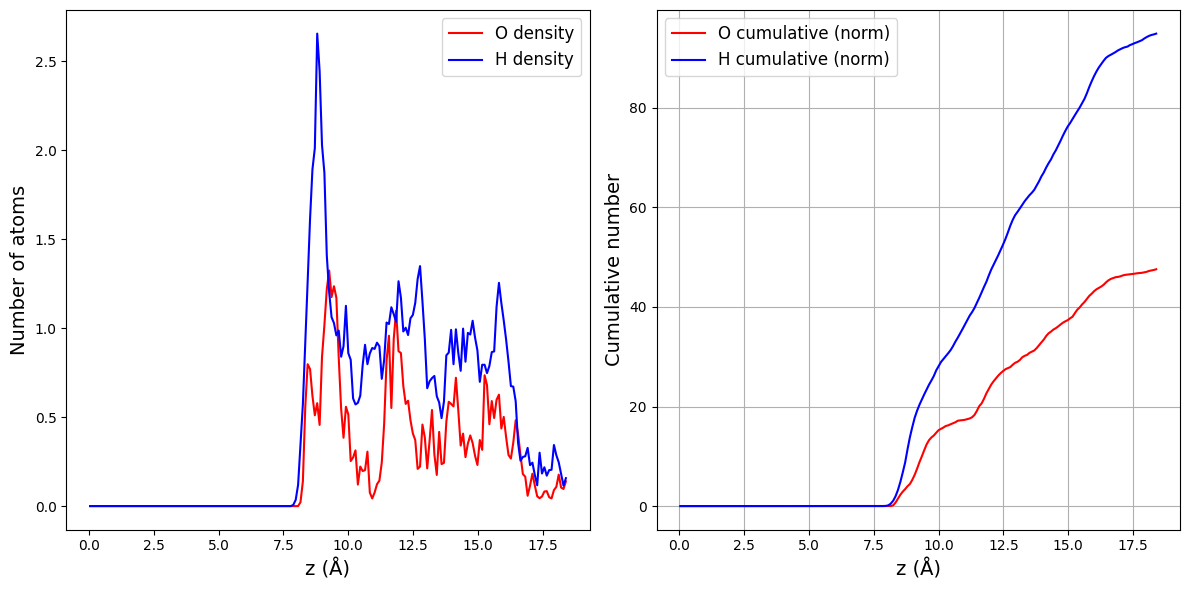

In [9]:
import MDAnalysis as mda
import numpy as np
import matplotlib.pyplot as plt
import os

project_name = "Cu"

home_dir = os.path.join(os.path.expanduser("~"), "Desktop")
trajecotry_file_path = os.path.join(home_dir, f"{project_name}-pos-1.xyz")

u1 = mda.Universe(trajecotry_file_path)
O_atoms = u1.select_atoms('name O')
H_atoms = u1.select_atoms('name H')

# Trajectory frame range
start =1000
stop = 2000
step = 1

# 분석 구간, bin 개수 등 설정
z_min = np.min(u1.atoms.positions[:,2])
z_max = np.max(u1.atoms.positions[:,2])
nbins = 200
z_bins = np.linspace(z_min, z_max, nbins+1)
o_hist = np.zeros(nbins)
h_hist = np.zeros(nbins)
total_frames = 0

for ts in u1.trajectory[start:stop:step]:
    o_z = O_atoms.positions[:,2]
    h_z = H_atoms.positions[:,2]
    o_hist += np.histogram(o_z, bins=z_bins)[0]
    h_hist += np.histogram(h_z, bins=z_bins)[0]
    total_frames += 1

# 평균화 (프레임 수로 나눔)
o_hist = o_hist / total_frames
h_hist = h_hist / total_frames

# CDF 계산 (누적합)
o_cdf = np.cumsum(o_hist)
h_cdf = np.cumsum(h_hist)
# 정규화 (0~1 구간) - 전체 누적 분율로 보고 싶으면 아래 주석 해제
o_cdf_norm = o_cdf / o_cdf[-1]
h_cdf_norm = h_cdf / h_cdf[-1]

# 각 bin의 중심 좌표
z_centers = 0.5 * (z_bins[:-1] + z_bins[1:])

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(z_centers, o_hist, label='O density', color='red')
plt.plot(z_centers, h_hist, label='H density', color='blue')
plt.xlabel('z (Å)', fontsize=14)
plt.ylabel('Number of atoms', fontsize=14)
plt.legend(fontsize=12)

plt.subplot(1,2,2)
plt.plot(z_centers, o_cdf, label='O cumulative (norm)', color='red')
plt.plot(z_centers, h_cdf, label='H cumulative (norm)', color='blue')
plt.xlabel('z (Å)', fontsize=14)
plt.ylabel('Cumulative number', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()

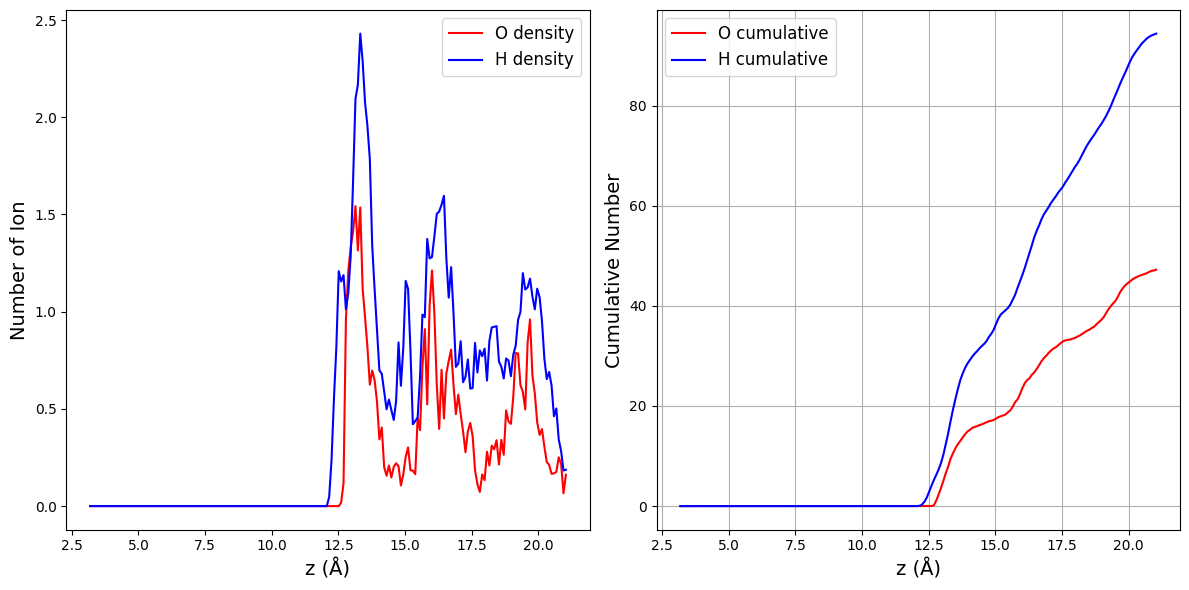

In [ ]:
import MDAnalysis as mda
import numpy as np
import matplotlib.pyplot as plt
import os

project_name = "CeO2"
home_dir = os.path.join(os.path.expanduser("~"), "Desktop")
trajecotry_file_path = os.path.join(home_dir, f"{project_name}-pos-1.xyz")

u1 = mda.Universe(trajecotry_file_path)
O_atoms = u1.select_atoms('name O and (prop z > 12)')
H_atoms = u1.select_atoms('name H')

# Trajectory frame 범위 설정
start = 1000
stop  = 2000
step  = 1

# 분석 구간, bin 개수 등 설정
z_min = np.min(u1.atoms.positions[:,2])
z_max = np.max(u1.atoms.positions[:,2])
nbins = 200
z_bins = np.linspace(z_min, z_max, nbins+1)
o_hist = np.zeros(nbins)
h_hist = np.zeros(nbins)
total_frames = 0

for ts in u1.trajectory[start:stop:step]:
    o_z = O_atoms.positions[:,2]
    h_z = H_atoms.positions[:,2]
    o_hist += np.histogram(o_z, bins=z_bins)[0]
    h_hist += np.histogram(h_z, bins=z_bins)[0]
    total_frames += 1

# 평균화 (프레임 수로 나눔)
o_hist = o_hist / total_frames
h_hist = h_hist / total_frames

# CDF 계산 (누적합)
o_cdf = np.cumsum(o_hist)
h_cdf = np.cumsum(h_hist)
# 정규화 (0~1 구간) - 전체 누적 분율로 보고 싶으면 아래 주석 해제
o_cdf_norm = o_cdf / o_cdf[-1]
h_cdf_norm = h_cdf / h_cdf[-1]

# 각 bin의 중심 좌표
z_centers = 0.5 * (z_bins[:-1] + z_bins[1:])

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(z_centers, o_hist, label='O density', color='red')
plt.plot(z_centers, h_hist, label='H density', color='blue')
plt.xlabel('z (Å)', fontsize=14)
plt.ylabel('Number of Ion', fontsize=14)
plt.legend(fontsize=12)

plt.subplot(1,2,2)
plt.plot(z_centers, o_cdf, label='O cumulative', color='red')
plt.plot(z_centers, h_cdf, label='H cumulative', color='blue')
plt.xlabel('z (Å)', fontsize=14)
plt.ylabel('Cumulative Number', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()


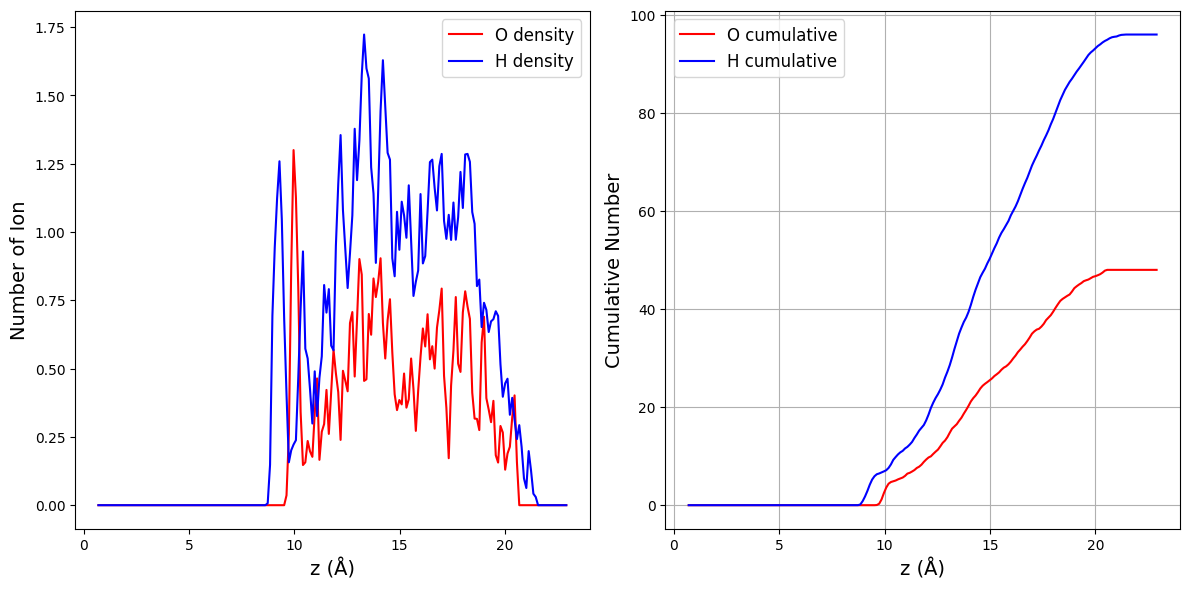

In [ ]:
import MDAnalysis as mda
import numpy as np
import matplotlib.pyplot as plt
import os

project_name = "CeO2_Cu"
home_dir = os.path.join(os.path.expanduser("~"), "Desktop")
trajecotry_file_path = os.path.join(home_dir, f"{project_name}-pos-1.xyz")

u1 = mda.Universe(trajecotry_file_path)
O_atoms = u1.select_atoms('bynum 227:274')
H_atoms = u1.select_atoms('bynum 131:226')

# Trajectory frame 범위 설정
start = 2000
stop  = 3000
step  = 1

# 분석 구간, bin 개수 등 설정
z_min = np.min(u1.atoms.positions[:,2])
z_max = np.max(u1.atoms.positions[:,2])
nbins = 200
z_bins = np.linspace(z_min, z_max, nbins+1)
o_hist = np.zeros(nbins)
h_hist = np.zeros(nbins)
total_frames = 0

for ts in u1.trajectory[start:stop:step]:
    o_z = O_atoms.positions[:,2]
    h_z = H_atoms.positions[:,2]
    o_hist += np.histogram(o_z, bins=z_bins)[0]
    h_hist += np.histogram(h_z, bins=z_bins)[0]
    total_frames += 1

# 평균화 (프레임 수로 나눔)
o_hist = o_hist / total_frames
h_hist = h_hist / total_frames

# CDF 계산 (누적합)
o_cdf = np.cumsum(o_hist)
h_cdf = np.cumsum(h_hist)
# 정규화 (0~1 구간) - 전체 누적 분율로 보고 싶으면 아래 주석 해제
o_cdf_norm = o_cdf / o_cdf[-1]
h_cdf_norm = h_cdf / h_cdf[-1]

# 각 bin의 중심 좌표
z_centers = 0.5 * (z_bins[:-1] + z_bins[1:])

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(z_centers, o_hist, label='O density', color='red')
plt.plot(z_centers, h_hist, label='H density', color='blue')
plt.xlabel('z (Å)', fontsize=14)
plt.ylabel('Number of Ion', fontsize=14)
plt.legend(fontsize=12)

plt.subplot(1,2,2)
plt.plot(z_centers, o_cdf, label='O cumulative', color='red')
plt.plot(z_centers, h_cdf, label='H cumulative', color='blue')
plt.xlabel('z (Å)', fontsize=14)
plt.ylabel('Cumulative Number', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()


# **Convergence**

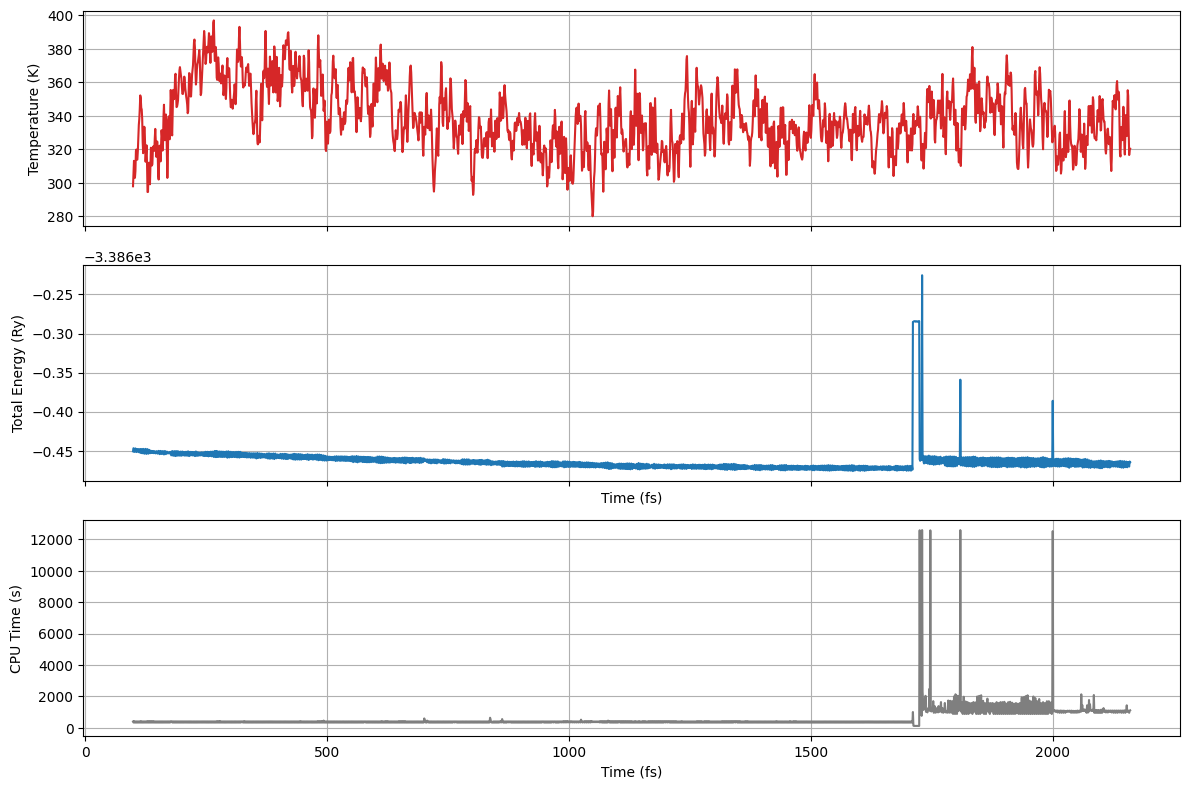

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import os

file_name = "CeO2-1.ener"
desktop_dir = os.path.join(os.path.expanduser("~"), "Desktop")
ener_file = os.path.join(desktop_dir, file_name)

# columns: 0=md_step, 1=time_fs, 2=e_kin, 3=temp, 4=e_pot, 5=e_tot, 6=cpu_time

data = np.loadtxt(ener_file, comments='#', skiprows=100, usecols=(1, 3, 5, 6))
time_fs, temp, e_tot, cpu_time = data[:,0], data[:,1], data[:,2], data[:,3]

fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

# 위: 온도
axes[0].plot(time_fs, temp, lw=1.5, color='tab:red')
axes[0].set_ylabel('Temperature (K)')
axes[0].ticklabel_format(style='plain', axis='y')
axes[0].grid(True)

# 아래: 에너지
axes[1].plot(time_fs, e_tot, lw=1.5, color='tab:blue')
axes[1].set_xlabel('Time (fs)')
axes[1].set_ylabel('Total Energy (Ry)')
axes[1].ticklabel_format(style='plain', axis='y')
axes[1].grid(True)

axes[2].plot(time_fs, cpu_time, lw=1.5, color='tab:grey')
axes[2].set_xlabel('Time (fs)')
axes[2].set_ylabel('CPU Time (s)')
axes[2].ticklabel_format(style='plain', axis='y')
axes[2].grid(True)

plt.tight_layout()
plt.show()


In [ ]:
csv_file = "C:\\Users\\Jihoon\\Desktop\\CeO2_Cu-1_energy.csv"
np.savetxt(
    csv_file, 
    np.column_stack((time_fs, property)), 
    delimiter=',', 
    header='time_fs,energy', 
    comments='',
    fmt='%.8f' 
)

In [ ]:
import os
from tkinter import filedialog

desktop_dir = os.path.join(os.path.expanduser("~"), "Desktop")

# 입력 파일명
report_file = filedialog.askopenfilename(
    title="Select report file",
    filetypes=[("Report files", "*REPORT*"), ("All files", "*.*")]
)

# 임시 리스트
cv_list = []
lambda_list = []
energy_list = []

# 파일 파싱
with open(report_file, 'r', encoding='utf-8') as f:
    for line in f:
        if 'cc' in line:
            tokens = line.split()
            if len(tokens) >= 3:
                cv_list.append(tokens[2]) 
                
        # 'b_m'이 포함된 줄의 두 번째 값 (lambda)
        if 'b_m' in line:
            tokens = line.split()
            if len(tokens) >= 2:
                lambda_list.append(tokens[1])

        if 'e_b' in line:
            tokens = line.split()
            if len(tokens) >= 2:
                energy_list.append(tokens[1])

# 길이 맞추기 (짧은 쪽 기준)
n = min(len(cv_list), len(lambda_list), len(energy_list))
cv_list = cv_list[:n]
lambda_list = lambda_list[:n]
energy_list = energy_list[:n]

data = [(float(cv_list[i]), float(lambda_list[i]), float(energy_list[i])) for i in range(n)]

# CV 값 기준 정렬
data.sort(key=lambda x: x[0])

# grad.dat 파일로 저장
with open(os.path.join(desktop_dir,'grad.dat'), 'w', encoding='utf-8') as out:
    for cv, lamb, ener in data:
        out.write(f"{cv:.8f} {lamb:.8f} {ener:.8f}\n")

print("Saved grad.dat (sorted, first 1000 rows).")


Saved grad.dat (sorted, first 1000 rows).


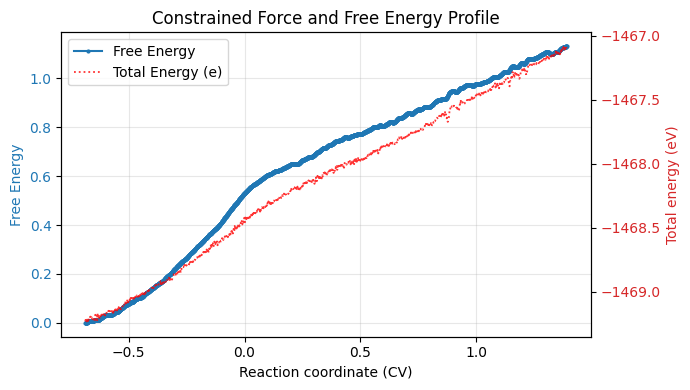

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

# grad.dat 경로 (데스크탑)
desktop_dir = os.path.join(os.path.expanduser("~"), "Desktop")
grad_path = os.path.join(desktop_dir, "grad.dat")

# grad.dat에서 데이터 읽기
data = np.loadtxt(grad_path)
r = data[:, 0]    # reaction coordinate (CV)
g = data[:, 1]    # lambda (구속력)
e = data[:, 2]    # free energy (eV)

# Free energy profile 계산 (trapezoidal integration)
fe = np.zeros_like(r)
for i in range(1, len(r)):
    fe[i] = fe[i-1] + 0.5 * (r[i] - r[i-1]) * (g[i] + g[i-1])

# Plot
fig, ax1 = plt.subplots(figsize=(7, 4))

# 첫 번째 y축: lambda(구속력)
color1 = 'tab:blue'
ax1.set_xlabel('Reaction coordinate (CV)')
ax1.set_ylabel('Free Energy', color=color1)
ax1.plot(r, fe, marker='o', markersize=2, linewidth=1.5, color=color1, label='Free Energy')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(True, which='both', axis='both', alpha=0.3)

# 두 번째 y축: Free energy profile
ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('Total energy (eV)', color=color2)
ax2.plot(r, e, linestyle=':', color='red', linewidth=1.3, alpha=0.8, label='Total Energy (e)')
ax2.tick_params(axis='y', labelcolor=color2)

# Legend (좌/우 데이터 모두 표시)
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='best')

plt.title('Constrained Force and Free Energy Profile')
plt.tight_layout()
plt.show()
